## A Micro-Xception Model to Classify the Kaggle Plant Seedlings Dataset
#### Kevin Maher
#### Regis University MSDS 686 Deep Learning
#### Dr. Geena Kim, Professor
#### October 20, 2018

### Introduction

A Micro-Xception style model is presented as a method of classifying the Kaggle Plant Seedlings dataset (Kaggle [1] 2017) (Giselsson, et. al. [10], 2017).  The model is a derivation of the well-known Xception image classification architecture (Chollet [3], 2016). The Xception style model has been reduced in size and modified in an effort to better fit the computing resources available and in an effort to perform well on the Plant Seedlings classification problem.  L2 Regularization was added to the model and appears to have improved performance.  The final model appears to have performed well, achieving a score of 0.98614 on Kaggle.  If this were still an open competition the best achieved score for this model would be tied with a group that is in the upper 4.8-6.3% of scores.  Given the limited time frame for the project in the last few weeks of a university semester, The results appear to be very good. 

<img src="img/L2_micro_xception_89_epoch.png">

Early in the project the full Xception model was attempted on the problem.  This was tried even though it is believed that the Image Net weights used in the original Xception model are unlikely to transfer well to this data set because the images for the problem at hand are only of plant seedlings and there were 1,000 different categories of images in the Image Net set (Chollet [2], 2018).  Early modeling efforts using the original Xception model and weights produced an accuracy on a validation subset of the Kaggle training data of 75.5%.  This model used the original weights from Image Net but trained the layers from block 13 upwards in the Xception model.  Thus only part of the Xception model was retrained on the new data, most of the model used the Image Net Weights.  The author was not able to train a full Xception model to full depth because of memory limitations in the computer hardware available.  The 75% accuracy was considered unacceptable and the search for a more appropriate model began.  This first model is documented in the file 'plant_xception.py' in the Git repository linked at the end of this notebook.  

The decision was made to search for a model that would fit the problem well and train with the computing and semester time resources available.  In this process both Xception and Inception V3 style models were tried (Szegedy, et. al. [4], 2015).  Both were modified to a reduced size from their original form by removing blocks of code and layers. This was done in order to better fit the available computing resources and hopefully to  produce a model that trained faster.  At the end of the project the modified Xception style architecture slightly out-performed the modified Inception architecture in classification accuracy.  However the models produced accuracy results that were very close and the possible combinations of blocks and block sizes for these models are endless so it would not be reasonable to conclude from these tests that one architecture is superior to the other in general terms.  The final model can be found in the files shown below in the Git repository.

In [16]:
# $plant_micro_xception_L2_Reg_test_70_30.py  
# $plant_micro_xception_L2_Reg_submission.py  

### Implementation

The project was implemented in Python 3.  Keras and Tensorflow were used for the convolutional neural network models.  Pandas and Numpy are two other key libraries used in the code.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
print('Python: ', sys.version)
import pandas
print('Pandas: ', pandas.__version__)
import numpy
print('Numpy: ', numpy.__version__)
import keras
print('Keras: ', keras.__version__)
import tensorflow
print('TensorFlow: ', tensorflow.__version__)

Python:  3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Pandas:  0.23.0
Numpy:  1.14.3
Keras:  2.2.2
TensorFlow:  1.10.0


### The Modified Xception Architecture

The Xception model was derived directly from code provided in Keras by Chollet (Chollet [3], 2016). Through a number of experiments it was changed in several ways in a search for accuracy and consistency on the plant seedling classification data. The code for the new model can be found below or in the Git repository in the Python file '$plant_micro_xception_L2_Reg_test_70_30.py'.  
  
The first and second blocks of the model were retained along with their residual layers. Blocks 3 and 4 were removed in the interest of a smaller model. The middle 'for' loop that creates 8 blocks in the original model was reduced to producing only 2 blocks in the new model. The last two blocks after the 'for' loop were retained but the number of filters was drastically reduced. The original Xception model can be examined by opening the file 'xception.py' in the Python Keras implementation. It can be noted that the number of filters tends to grow with each block and often within a block. With many fewer blocks in the new reduced size model this growth was restrained. It was also necessary to reduce the filter sizes to account for the removed blocks so that the sizes would remain compatible and the model would compile. The goal was a smaller model that would fit in memory while training all of the layers and not excessively overfit the problem.  
  
A top layer was derived specifically to match the plant seedlings challenge. Early experimentation tended to show that two dense layers gave better accuracy than one, so two dense layers of sizes 256 then 64 were utilized. The output layer is a 'softmax' layer matching the 12 classes in the problem and is typical of output layers for convolutional neural network (CNN) models where an image can contain only one from a number of classes (Chollet [2], 2018). Additionally, early experimentation showed that a smaller learning rate might benefit the model and be combined with a decay rate. An 'Adam' optimizer was used because of its reputation for achieving good results fast, but time did not permit exploration of other optimizer options (Brownlee [11], 2017). The learning rate was set at 0.0008 and the decay set to 0.001.  
  
Another modification was made in an effort to help improve the model. L2 regularization was added to every layer of the Xception model, including all of the separable convolution blocks that represent the Xception-style architecture. L2 regularization was used with its normal default value of 0.001. It had a small beneficial effect on the model in training and appears to have had a significant effect upon the best result when submitted to Kaggle. Overall accuracy potential seems to have improved along with the ability to fit previously unseen data such as the Kaggle web site test set. The best Kaggle score achieved without regularization was 0.97984, not bad, but not as high as the model scored with regularization (0.98614).  

### The Modified Micro-Xception Code

In [3]:
# imports
import os
import math

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import GlobalMaxPooling2D
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import SeparableConv2D
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import regularizers
import tensorflow as tf
print('done with imports')

done with imports


In [3]:
# model building function
def build_model(input_shape=None):
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=im_size,
        min_size=24,
        data_format=K.image_data_format(),
        require_flatten=False,
        weights='None')

    img_input = Input(shape=input_shape)
    reg = regularizers.l2(0.001)
    
    # first block
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1', kernel_regularizer=reg)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False, name='residual_conv2d_1', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual) 
   
    # second block
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block2_sepconv2', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    # second residual
    residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False, name='residual_conv2d_2', kernel_regularizer=reg)(x)
    residual = BatchNormalization()(residual)

    for i in range(2):
        residual = x
        prefix = 'block' + str(i + 3)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1', kernel_regularizer=reg)(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2', kernel_regularizer=reg)(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3', kernel_regularizer=reg)(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(384, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # output blocks - block 21  
    x = Activation('relu', name='block21_sepconv1_act')(x)
    x = SeparableConv2D(384, (3, 3), padding='same', use_bias=False, name='block21_sepconv1', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block21_sepconv1_bn')(x)
    x = Activation('relu', name='block21_sepconv2_act')(x)
    x = SeparableConv2D(384, (3, 3), padding='same', use_bias=False, name='block21_sepconv2', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block21_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    # block 22
    x = SeparableConv2D(512, (3, 3), padding='same', use_bias=False, name='block22_sepconv1', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block22_sepconv1_bn')(x)
    x = Activation('relu', name='block22_sepconv1_act')(x)

    x = SeparableConv2D(768, (3, 3), padding='same', use_bias=False, name='block22_sepconv2', kernel_regularizer=reg)(x)
    x = BatchNormalization(name='block22_sepconv2_bn')(x)
    x = Activation('relu', name='block22_sepconv2_act')(x)
    
    # model finish
    x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = Dense(64, activation='relu', kernel_regularizer=reg)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(img_input, x, name='micro_xception_bn_v1')
    opt = optimizers.Adam(lr=0.0008, decay=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

print('model function complete')

model function complete


In [5]:
# instantiate the model and check its size
EPOCHS = 120
LAST_EPOCH = 0
REPEATS = 10
train_size= 3319
validation_size = 1431
test_size = 794
batch_size = 20
seed = 321
im_size = 224
num_classes = 12
model = build_model(input_shape=(im_size, im_size, 3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### Model Setup Results

As can be seen in the code above, the modified model has around 1.66 million parameters, most of which are trainable. The original Xception model has approximately 22.9 million parameters (Keras [5]). The goal of providing a much smaller and simpler model that still fits the problem well has been achieved as can be seen from the final best Kaggle score of 0.98614. The model appears to have been successfully adapted to this problem which is smaller and simpler than the original Image Net data that the larger original Xception model was designed for. 

### Model Training

Code for the setup of the model was developed using concepts in the course textbook (Chollet [2], 2018).  An image generator was used to randomize the input images in the hope that the model would generalize better.  The image generator rotated, flipped, skewed, shifted and zoomed the images on a randomized basis with the goal of always presenting the network with a 'different' image so that it would learn global patterns that would generalize well (Allred [7], 2017). The image augmentation used in the development of this model was fairly standard and time did not permit experimentation with such items as coloring and lighting.  This may not have helped much on this problem since a visual examination of the images appears to show that they are fairly consistent in their color and lighting. 

In [ ]:
# only 2 epochs are shown to demo the code in the notebook, and only one image repeat
# these are set to 120 and 10 in the actual code
K.set_floatx('float32')

base_dir = r'C:\Users\Vette\Desktop\Regis\#Plants2'
data_dir = r'data_mx_l2_test_70_30'
data_path = os.path.join(base_dir, data_dir)
os.mkdir(data_path)

train_dir = os.path.join(base_dir, 'train70')
validation_dir = os.path.join(base_dir, 'validation30')
test_dir = os.path.join(base_dir, 'test_submission')

EPOCHS = 2
LAST_EPOCH = 0
REPEATS = 1
train_size= 3319
validation_size = 1431
test_size = 794
batch_size = 20
seed = 321
im_size = 224
num_classes = 12

base_train_steps = math.ceil(train_size / batch_size)
base_val_steps = math.ceil(validation_size / batch_size)
base_test_steps = math.ceil(test_size / batch_size)
print(base_train_steps, base_val_steps, base_test_steps)


train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=45,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(im_size, im_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                target_size=(im_size, im_size),
                                                                batch_size=batch_size,
                                                                class_mode='categorical')
print('done with setup')

Code for the creation of the Kaggle submission was adapted for my environment using a script from the Kaggle website by Michael Kazachok (Kazachok [6]).  In the interest of pushing the project forward and concentrating on the modeling task, Michael's submission code was largely used as-is.  His model and problem setup code differ substantially from that used for this report and the accuracy of the model presented here appears to be higher.  Michael claimed a Kaggle score of 0.97103, the Xception model above had a best score or 0.98614 (Kaggle micro-averaged F1 score, higher is better).

In [ ]:
INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

test_dict = {
    'image': [],
    'label': []
}

import imageio
from skimage.transform import resize as imresize

# Resize all image to 51x51 
def img_reshape(img):
    img = imresize(img, (im_size, im_size, 3))  # auto-rescales image to 0-1
    return img

# get image tag
def img_label(path):
    return str(str(path.split('/')[-1]))

# fill train and test dict
def fill_dict(path, some_dict):
    print(path)
    files = os.listdir(path)
    for p in files:
        p_full = os.path.join(path, p)
        img = imageio.imread(p_full)
        img = img_reshape(img)
        some_dict['image'].append(img)
        some_dict['label'].append(img_label(p))

    return some_dict

test_dict = fill_dict(test_dir, test_dict)

X_test = np.array(test_dict['image'])
label = test_dict['label']
print('done with submisiision setup')

The code to run the model has been written to achieve several objectives in addition to training the model. First, it makes a save of model history every epoch. Model training takes 6-800 seconds per epoch which results in long training times. This is partly because of the up-sampling of training images made possible by the randomization of those images in the image data generator. A model training run can take 20 hours or more. Because of long training times it is desirable that unpromising models be terminated early, but also desirable to get at least some data from the run. This data is for the number of epochs that complete before the run is terminated.   
   
In order to get the data from runs that are terminated early the code is written so that data is saved every epoch. The "initial_epoch" parameter of the "fit_generator" function is set to that only one epoch runs at a time. It is run in a for loop and the history for each epoch is collected and placed into an accumulating Pandas data frame and saved to disk. This way history data including accuracy and losses on the training and validation data is obtained even if a decision is made to terminate a run early. Epochs that are promising as determined by validation accuracy are saved for Kaggle submission. The code for how this is accomplished is below. It is not recommended to run this code in Jupyter notebook due to its long run time. Instead the code should be run either from the command line or using an IDE from files in the Git repository referenced below.   

In [ ]:
np.random.seed(seed)
df = None

with tf.device('/gpu:0'):
    model = build_model(input_shape=(im_size, im_size, 3))
    
    for i in range(LAST_EPOCH + 1, EPOCHS+1):
        j = i-1
        history = model.fit_generator(train_generator,
                                      steps_per_epoch=base_train_steps * REPEATS,
                                      epochs=i,
                                      validation_data=validation_generator,
                                      validation_steps=base_val_steps,
                                      verbose=1,
                                      initial_epoch=j,
                                      workers=1)

        accs = history.history['acc']
        val_accs = history.history['val_acc']
        losses = history.history['loss']
        val_losses = history.history['val_loss']
        
        if val_accs[-1] >= 0.98:
            prob = model.predict(X_test, verbose=1)
            pred = prob.argmax(axis=-1)
            sub = pd.DataFrame({"file": label, "species": [INV_CLASS[p] for p in pred]})
            
            submission_path = os.path.join(data_path, 'sub_mx_l2_70_30_%d.csv' % i)
            sub.to_csv(submission_path, index=False, header=True)
            
            probability_path = os.path.join(data_path, 'preds_mx_l2_70_30_%d.csv' % i)
            np.savetxt(probability_path, prob, delimiter=",")
            
            try:
                # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
                weights_path = os.path.join(data_path, 'weights_mx_l2_70_30_%d.h5' % i)
                model.save_weights(weights_path)
                print("Saved model to disk")
            except:
                print('Exception saving model')
                
        data = {'epoch': i, 'accs': accs[-1], 'val_accs': val_accs[-1], 'losses': losses[-1], 'val_losses': val_losses[-1]}
        
        if df is None:
            df = pd.DataFrame(data=data, index=[0])
        else:
            temp = pd.DataFrame(data=data, index=[0])
            df = df.append(temp, ignore_index=True)

        df.reset_index(inplace=True, drop=True)
        df_path = os.path.join(data_path, '$df_mx_l2_70_30_%d.csv' % i)
        df.to_csv(df_path)
        print(df.tail())    
    print('completd model run')

### Plotting

While it might be observed that the model still over fits to some degree, the stability epoch-to-epoch is very good after a few early dropouts before the 24th epoch. It is difficult to tell if the model has reached its full potential, even after 120 epochs. Also shown are plots for the same Xception based model without the L2 regularization. While the model without regularization appears to reach high accuracy early in the training process it over fits and starts to suffer from worse training metrics. Some of the outputs for the model without L2 regularization were tried on Kaggle using the same training parameters as the model with L2 regularization. The best Kaggle score achieved without regularization was 0.97984, not bad, but not as high as the model with regularization (0.98614). 

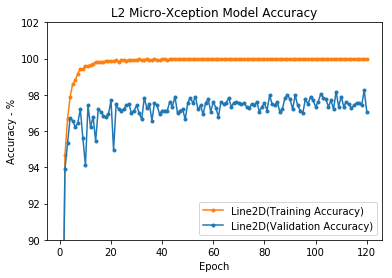

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'data/df_mx_l2_70_30_120.csv')

plt.figure()
p1 =plt.plot(df['epoch'], df['accs']*100.0, color='tab:orange', marker='.', label='Training Accuracy')
p2 =plt.plot(df['epoch'], df['val_accs']*100.0, color='tab:blue', marker='.', label='Validation Accuracy')
p = p1 + p2
plt.title('L2 Micro-Xception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy - %')
plt.legend(p, loc='lower right')
plt.ylim(90.0, 102.0)
plt.show()

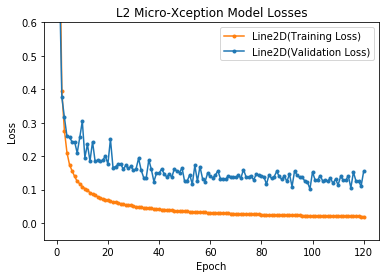

In [10]:
plt.figure()
p1 =plt.plot(df['epoch'], df['losses'], color='tab:orange', marker='.', label='Training Loss')
p2 =plt.plot(df['epoch'], df['val_losses'], color='tab:blue', marker='.', label='Validation Loss')
p = p1 + p2
plt.title('L2 Micro-Xception Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(p, loc='upper right')
plt.ylim(-0.05, 0.6)
plt.show()

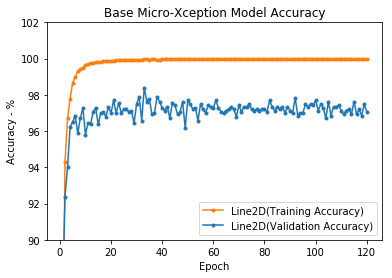

In [5]:
df = pd.read_csv(r'data/base_df_mx_70_30_120.csv')

plt.figure()
p1 =plt.plot(df['epoch'], df['accs']*100.0, color='tab:orange', marker='.', label='Training Accuracy')
p2 =plt.plot(df['epoch'], df['val_accs']*100.0, color='tab:blue', marker='.', label='Validation Accuracy')
p = p1 + p2
plt.title('Base Micro-Xception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy - %')
plt.legend(p, loc='lower right')
plt.ylim(90.0, 102.0)
plt.show()

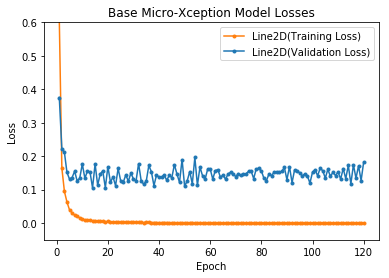

In [12]:
plt.figure()
p1 =plt.plot(df['epoch'], df['losses'], color='tab:orange', marker='.', label='Training Loss')
p2 =plt.plot(df['epoch'], df['val_losses'], color='tab:blue', marker='.', label='Validation Loss')
p = p1 + p2
plt.title('Base Micro-Xception Model Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(p, loc='upper right')
plt.ylim(-0.05, 0.6)
plt.show()

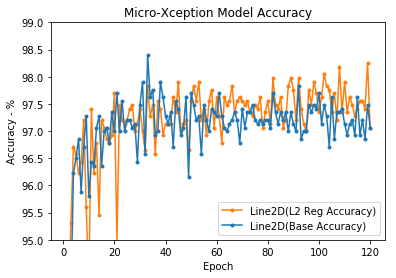

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

dfl2 = pd.read_csv(r'data/df_mx_l2_70_30_120.csv')
df = pd.read_csv(r'data/base_df_mx_70_30_120.csv')

plt.figure()
p1 =plt.plot(dfl2['epoch'], dfl2['val_accs']*100.0, color='tab:orange', marker='.', label='L2 Reg Accuracy')
p2 =plt.plot(df['epoch'], df['val_accs']*100.0, color='tab:blue', marker='.', label='Base Accuracy')
p = p1 + p2
plt.title('Micro-Xception Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy - %')
plt.legend(p, loc='lower right')
plt.ylim(95.0, 99.0)
plt.show()

### Training Notes

One possible contentious training decision was to present each image to the model 10 times per epoch. Early experiments showed that this improved accuracy, though at the cost of long training times. It is also the approach taken by one of the Kaggle scripts that helped to inspire this project (Kazachok [6], 2018). It needs to be remembered that the image data generator randomly changes each image. Thus it is not true that the same image is presented to the network for training 10 times, rather a randomized version of the image is presented. It appears that presenting the image multiple times where it is randomly different each time simulates the effect of a larger set of training images.  
  
Another training item is that the model was developed using a 70:30 split of the Kaggle training data into training and validation data sets. The best score obtained on Kaggle for the model as trained on 70% of the training data was 0.97607. This is not at all a bad score, but it is from a model that leaves out 30% of the potential training data. In the interest of a better score on the Kaggle test set the model was retrained using 100% of the available training data. This resulted in the model generalizing better to the Kaggle test set and the score reported of 0.98614. Note that training on the full amount of data available raised the final Kaggle score by a little over 0.1, so it appears to have been worth the effort to train on the full set and not leave any data out from final model training.  

### Enhanced Image Processing

Enhanced image processing was attempted using code from two sources.  The processing techniques were an attempt to enhance the images by removing the background so that the model would hopefully concentrate on the plant or weed in the picture.  Two different processing techniques were tried.  Neither effort appeared to be successful on the Xception model utilized above.  Time did not permit exploration of models designed around the enhanced images.  
   
The first process tried was a mask using the HSA color space that removed the background (NikKonst [8], 2018).  This produced striking images with the background black and the plant in green.  However, the best accuracy that was obtained using the modified Xception model and a 70:30 split of the training data was 96.6%  after 20 training epochs.  The final model presented above had achieved an accuracy score of 97.7% by the same epoch.  Because of the challenges presented by limited time for the project and the length of training to many epochs, this effort was abandoned.  
   
The second process tried produced images with a black background and gray scale images bu using CIELUV color processing (Te [9], 2018).  This could have the advantage of requiring only one color channel but also loses color information retaining brightness.  It only achieved 90.6% accuracy on the 30% validation set.  If there had been more time available for model training, then the green images of Te's process could have been tried.   
   
Because these image processing techniques did not produce any apparent gains in accuracy their training was abandoned early.  This is because of the semester time constraints and the long training time (around 700 seconds per epoch).  Comparitive plots of accuracy and losses are shown below for the base model and the models with image augmentation.

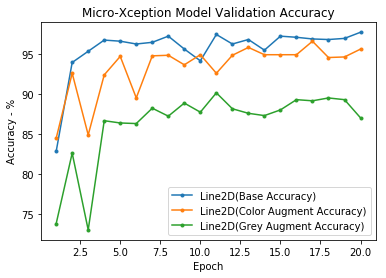

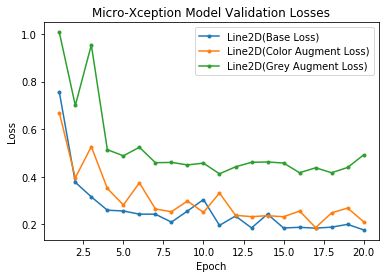

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df0 = pd.read_csv('data/img_augment/df_mx_l2_70_30_20.csv')
df1 = pd.read_csv('data/img_augment/$df_mx_l2_img_aug_70_30_20.csv')
df2 = pd.read_csv('data/img_augment/$df_mx_l2_img_aug_V2_70_30_20.csv')


plt.figure()
p1 =plt.plot(df0['epoch'], df0['val_accs']*100.0, color='tab:blue', marker='.', label='Base Accuracy')
p2 =plt.plot(df1['epoch'], df1['val_accs']*100.0, color='tab:orange', marker='.', label='Color Augment Accuracy')
p3 =plt.plot(df2['epoch'], df2['val_accs']*100.0, color='tab:green', marker='.', label='Grey Augment Accuracy')
p = p1 + p2 + p3
plt.title('Micro-Xception Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy - %')
plt.legend(p, loc='lower right')
plt.show()

plt.figure()
p1 =plt.plot(df0['epoch'], df0['val_losses'], color='tab:blue', marker='.', label='Base Loss')
p2 =plt.plot(df1['epoch'], df1['val_losses'], color='tab:orange', marker='.', label='Color Augment Loss')
p3 =plt.plot(df2['epoch'], df2['val_losses'], color='tab:green', marker='.', label='Grey Augment Loss')
p = p1 + p2 + p3
plt.title('Micro-Xception Model Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(p, loc='upper right')
plt.show()

### Inception Model

A modified and reduced size Inception V3 style architecture was also tried (Szegedy, et. al.[4] 2015).  Again, this model used L2 regularization.  The accuracy plotted below is for a 70:30 split of the Kaggle training data into training and validation data sets.  The accuracy plot uses accuracy on the validation as its metric.  As can be observed from the plots, the Inception style model was a small amount less accurate than the Xception style model.  As a result the Xception style model was pursued further and work on the Inception style models dropped.  Code for the Inception style model can be found in the Git repository as '$plant_micro_inception_L2_test_70_30.py'.  

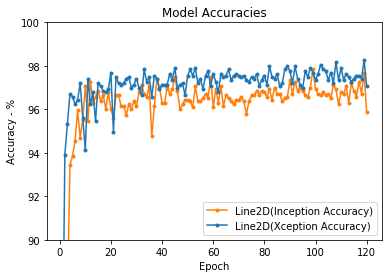

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

dfI = pd.read_csv(r'data/df_incp_l2_70_30_120.csv')
dfX = pd.read_csv(r'data/df_mx_l2_70_30_120.csv')

plt.figure()
p1 = plt.plot(dfI['epoch'], dfI['val_accs']*100.0, color='tab:orange', marker='.', label='Inception Accuracy')
p2 = plt.plot(dfX['epoch'], dfX['val_accs']*100.0, color='tab:blue', marker='.', label='Xception Accuracy')
p = p1 + p2
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy - %')
plt.legend(p, loc='lower right')
plt.ylim(90.0, 100.0)
plt.show()

### Best Kaggle Scores for the Xception Model

Due to long run times for the model, originally only 60 epochs were originally run.  These scores were obtained on a second run from epoch 60 to 90 where the weights of the 60 epoch run were reloaded to start training.  Training was performed using the full Kaggle training data set and 10 replicates of each input image.  These replicates can be considered as somewhat different imput images due to the random effects of the image data generator.

<img src="img/L2_micro_xception_best_submissions.png">

### Possible Improvements

It might be possble to improve the Kaggle score by utilizing model stacking or averaging.  For example, the Micro-Xception and Micro-Inception models presented here both provide similar and high accuracy.  But, they are very different models so it is quite possible that their combination would reinforce each others strengths if the models were combined.  Another possibility for model combination is to utilize one of the variants (different 'alpha' sizes) of the MobileNetV2 architecture as an alternate ot third model in the stack.  MobileNetV2 is small and the alpha parameter can be used to fit its size to the problem.  It appears to be a possible model to use in the Plant Seedlings challenge because the alpha parameter can be chosen such that the model matches model sizes that appear to have worked well on the problem.

Also it must be noted that only a small number of the possible sizes and hyperparameters for the Micro-Xception and Micro-Inception models could be tried in the semester time frame.  It is possible that these models might be further optimized.  My recomendation, however, would be to try model stacking with the three models noted above as a method of improving on an already good Kaggle score.  Model stacking is noted by Chollet as a good method for obtaining a high score in Kaggle-type competitions (Chollet [2], 2016).

### GIT Repository Link

https://github.com/Vettejeep/MSDS_686

### References:
[1] Kaggle. Plant Seedlings Classification (2017).  Retrieved from: https://www.kaggle.com/c/plant-seedlings-classification.  
[2] Chollet, Francois (2018).  Deep Learning with Python.  Manning.  Shelter Island, N.Y.  
[3] Chollet, Francois (2016).  Xception: Deep Learning with Depthwise Separable Convolutions.  Cornell University Library.  Retrieved from: https://arxiv.org/abs/1610.02357.  
[4] Szegedy, Christian; Vanhoucke, Vincent; Ioffe, Sergey; Shlens, Jonathon; Wojna, Zbigniew (2015).  Rethinking the Inception Architecture for Computer Vision.  Cornell University Library.  Retrieved from: https://arxiv.org/abs/1512.00567.  
[5] Keras.  Applications.  Keras Documentation.  Retrieved from: https://keras.io/applications/.  
[6] Kazachok, Michael (2018).  Keras Simple Model (0.97103 Best Public Score).  Kaggle.  Retrieved from: https://www.kaggle.com/miklgr500/keras-simple-model-0-97103-best-public-score.  
[7] Allred, Ryan (2017).  Image Augmentation for Deep Learning using Keras and Histogram Equalization.  Towards Data Science.  Retrieved from: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085.  
[8] NikKonst (2018).  Plant Seedlings with CNN and Image Processing.  Kaggle.  Retrieved from: https://www.kaggle.com/nikkonst/plant-seedlings-with-cnn-and-image-processing.  
[9] Te, Ian Chu (2018).  Background Removal (CIELUV Color Thresholding).  Kaggle. Retrieved from: https://www.kaggle.com/ianchute/background-removal-cieluv-color-thresholding.  
[10] Giselsson, Thomas Mosgaard; Jørgensen, Rasmus Nyholm; Jensen, Peter Kryger; Dyrmann, Mads; Midtiby, Henrik Skov (2017).  A Public Image Database for Benchmark of Plant Seedling Classification Algorithms.  Cornell University Library.  Retrieved from: https://arxiv.org/abs/1711.05458.  
[11] Brownlee, Jason Ph.D. (2017).  Gentle Introduction to the Adam Optimization Algorithm for Deep Learning.  Machine Learning Mastery.  Retrieved from: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/.  